# 25/04/2019 Update
Please check out my  [new embedding model](https://www.kaggle.com/benjibb/entity-embedding-neural-network), which I think is more promising than the existing method.

# 07/05/2017 Update

This project is based on my [GitHub link][1] and my research is based on  [this paper][2]. 

Instead of using Echo state network which was used in the Stanford research paper, we are going to use LSTM which is more advanced in training the neural network.

More updates will be provided to accommodate the dataset in this Kaggle challenge.  You can simply adjust it to choose your features and window for data.

Thank you all!

# Import module first


  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data
  [2]: http://cs229.stanford.edu/proj2012/BernalFokPidaparthi-FinancialMarketTimeSeriesPredictionwithRecurrentNeural.pdf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Using TensorFlow backend.


# Read data and transform them to pandas dataframe

In [0]:
# import all stock prices 
df = pd.read_csv("https://www.dropbox.com/s/iqm4jt9o9dorlup/prices-split-adjusted.csv?dl=1", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [0]:
df2 = pd.read_csv("https://www.dropbox.com/s/wda4zo86bv8k3ye/fundamentals.csv?dl=1")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


# Extract all symbols from the list

In [0]:
symbols = list(set(df.symbol))
len(symbols)

501

In [0]:
symbols[:11] # Example of what is in symbols

['WM', 'ACN', 'KMX', 'URI', 'DG', 'CBS', 'CERN', 'HON', 'AES', 'ATVI', 'PEG']

# Extract a particular price for stock in symbols
Use GOOG as an example

In [0]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


# Normalize the data

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


# Create training set and testing set

In [0]:
amount_of_features = len(df.columns) # 5
data = df.values
seq_len = 22
sequence_length = seq_len + 1 # index starting from 0
result = []

for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
  result.append(data[index: index + sequence_length]) # index : index + 22days

result = np.array(result)
row = round(0.9 * result.shape[0]) # 90% split
train = result[:int(row), :]

x_train = train[:, :-1] 
y_train = train[:, -1][:,-1]

x_test = result[int(row):, :-1] 
y_test = result[int(row):, -1][:,-1]


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

In [0]:
amount_of_features

5

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

* Samples. One sequence is one sample. A batch is comprised of one or more samples.
* Time Steps. One time step is one point of observation in the sample.
* Features. One feature is one observation at a time step.

## Build LSTM Model

In [0]:
d = 0.3
model = Sequential()

model.add(LSTM(256, input_shape=(seq_len, 5), return_sequences=True))
model.add(Dropout(d))

model.add(LSTM(256, input_shape=(seq_len, 5), return_sequences=False))
model.add(Dropout(d))

model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=512,epochs=30,validation_split=0.1,verbose=1)

Train on 1408 samples, validate on 157 samples
Epoch 1/30
 512/1408 [=========>....................] - ETA: 9s - loss: 0.1384 - acc: 0.0000e+00

KeyboardInterrupt: ignored

# Train the model

In [0]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(x_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


# Denormalize the data

In [0]:
df = pd.read_csv("https://www.dropbox.com/s/iqm4jt9o9dorlup/prices-split-adjusted.csv?dl=1", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df = df['adj close'].values.reshape(-1,1)
p = p.reshape(-1,1)
y_test = y_test.reshape(-1,1)
#return df.shape, p.shape
min_max_scaler = preprocessing.MinMaxScaler()
a = min_max_scaler.fit_transform(df)
newp = min_max_scaler.inverse_transform(p)
newy_test = min_max_scaler.inverse_transform(y_test)

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.00640 MSE (0.08 RMSE)
Test Score: 0.04427 MSE (0.21 RMSE)


(0.006397173842028403, 0.04427400428330761)

# Since the Kaggle dataset only contains a few years, the mean square error is not as small as my original model on GitHub.

With more than 40 years of data, we will get:

Train Score: 0.00006 MSE (0.01 RMSE)

Test Score: 0.00029 MSE (0.02 RMSE)

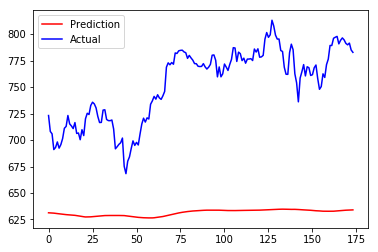

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

The result on my original model with more than 40 years of data.

![Result][1]

 Train Score: 0.00006 MSE (0.01 RMSE)

Test Score: 0.00029 MSE (0.02 RMSE)

  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/raw/master/result2.png

# Thank you all for reading
 If you have any question or concern, please leave a comment. Otherwise, see you next time!